In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

In [ ]:
def replace_zeros(df):
    """Заменяет нули на моду, исключая 0 как моду."""
    for col in df.select_dtypes(include=np.number):
        counts = df[col].value_counts()
        mode = counts.drop(0, errors='ignore').nlargest(1).index[0] if len(counts)>1 else df[col].mean()
        df[col] = df[col].replace(0, mode)
    return df

(1) Выполните масштабирование данных.

In [ ]:
data = pd.read_csv('diabetes.csv')

X = data.drop('Outcome', axis=1)
y = data['Outcome']

X = replace_zeros(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Балансировка данных
ros = RandomOverSampler(random_state=294)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=294)

Нули заменены на моду

In [ ]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,105,33.6,0.627,50
1,1,85,66,29,105,26.6,0.351,31
2,8,183,64,32,105,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,1,137,40,35,168,43.1,2.288,33


 (2) 1-ю конфигурацию сделайте следующую: в качестве слабых учеников возьмите SVM, KNN, метод решающих деревьев с параметрами по умолчанию, в качестве метамодели - логистическую регрессию.

In [ ]:
estimators_config1 = [
    ('svm', SVC()),
    ('knn', KNeighborsClassifier()),
    ('tree', DecisionTreeClassifier())
]
clf1 = StackingClassifier(estimators=estimators_config1, final_estimator=LogisticRegression())
clf1.fit(X_train, y_train)
print("Конфигурация 1:")
print(classification_report(y_test, clf1.predict(X_test)))

Конфигурация 1:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       104
           1       0.83      0.85      0.84        96

    accuracy                           0.84       200
   macro avg       0.84      0.85      0.84       200
weighted avg       0.85      0.84      0.85       200



(3) 2-ю конфигурацию возьмите с таким же набором слабых учеников, но для каждого задайте наилучшие гиперпараметры на основе выполненных ранее заданий.

In [ ]:
estimators_config2 = [
    ('svm', SVC(C=10)),
    ('knn', KNeighborsClassifier(n_neighbors=11)),
    ('tree', DecisionTreeClassifier(max_depth=3))
]
clf2 = StackingClassifier(estimators=estimators_config2, final_estimator=LogisticRegression())
clf2.fit(X_train, y_train)
print("\nКонфигурация 2:")
print(classification_report(y_test, clf2.predict(X_test)))


Конфигурация 2:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       104
           1       0.79      0.83      0.81        96

    accuracy                           0.81       200
   macro avg       0.82      0.82      0.81       200
weighted avg       0.82      0.81      0.82       200



 (4) 3-ю конфигурацию - возьмите по два слабых ученика по каждой модели (одна с гиперпараметрами по умолчанию, вторая - с наилучшими).

In [ ]:
estimators_config3 = [
    ('svm1', SVC()),
    ('svm2', SVC(C=10)),
    ('knn1', KNeighborsClassifier()),
    ('knn2', KNeighborsClassifier(n_neighbors=11)),
    ('tree1', DecisionTreeClassifier()),
    ('tree2', DecisionTreeClassifier(max_depth=3))
]
clf3 = StackingClassifier(estimators=estimators_config3, final_estimator=LogisticRegression())
clf3.fit(X_train, y_train)
print("\nКонфигурация 3:")
print(classification_report(y_test, clf3.predict(X_test)))


Конфигурация 3:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       104
           1       0.82      0.85      0.84        96

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



(5) Для каждого ансамбля моделей выведите его конфигурацию.

In [ ]:
print('Первая конфигурация')
print(clf1.estimators_)

print('Вторая конфигурация')
print(clf2.estimators_)

print('Третья конфигурация')
print(clf3.estimators_)

Первая конфигурация
[SVC(), KNeighborsClassifier(), DecisionTreeClassifier()]
Вторая конфигурация
[SVC(C=10), KNeighborsClassifier(n_neighbors=11), DecisionTreeClassifier(max_depth=3)]
Третья конфигурация
[SVC(), SVC(C=10), KNeighborsClassifier(), KNeighborsClassifier(n_neighbors=11), DecisionTreeClassifier(), DecisionTreeClassifier(max_depth=3)]


(6) Проведите сравнение (classification_report) с ранее выполненными работами. Позволило ли существенно улучшить качество прогноза заболевания такое усовершенствование алгоритма? Если есть возможность выполнить подбор гиперпараметров модели - сделайте!

Прошлые работы

SVC

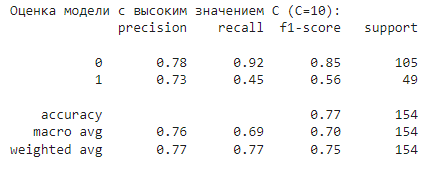

KNN

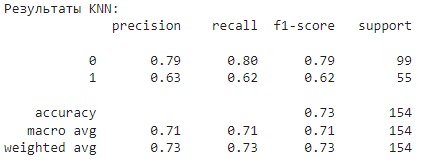

Дерево решений

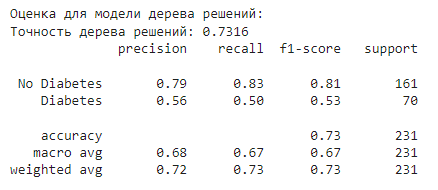

Качество увеличилось, но не существенно

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}
param_grid_tree = {'max_depth': [None, 3, 5, 7]}

grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid_tree, cv=5)

grid_svm.fit(X_train, y_train)
grid_knn.fit(X_train, y_train)
grid_tree.fit(X_train, y_train)


print("Лучшие параметры для SVM:", grid_svm.best_params_)
print("Лучшие параметры для KNN:", grid_knn.best_params_)
print("Лучшие параметры для Tree:", grid_tree.best_params_)

# Создание StackingClassifier с лучшими параметрами

estimators_config1_tuned = [
    ('svm', grid_svm.best_estimator_),
    ('knn', grid_knn.best_estimator_),
    ('tree', grid_tree.best_estimator_)
]

clf1_tuned = StackingClassifier(estimators=estimators_config1_tuned, final_estimator=LogisticRegression())
clf1_tuned.fit(X_train, y_train)

print("\nКонфигурация 1 (с подобранными параметрами):")
print(classification_report(y_test, clf1_tuned.predict(X_test)))

Лучшие параметры для SVM: {'C': 1, 'kernel': 'rbf'}
Лучшие параметры для KNN: {'n_neighbors': 3}
Лучшие параметры для Tree: {'max_depth': 7}

Конфигурация 1 (с подобранными параметрами):
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       104
           1       0.80      0.80      0.80        96

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200

